# 0. Dependências

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline
pd.options.display.max_rows = 10

/Users/arnaldo/miniconda3/envs/ml/lib/python3.5/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


# 1. Introdução 

**O objetivo principal do PCA é analisar os dados para identificar padrões visando reduzir a dimensionalidade dos dados com uma perda mínima de informação**. Uma possível aplicação seria o reconhecimento de padrões, onde queremos reduzir os custos computacionais e o erro da estimação de parâmetros pela redução da dimensionalidade do nosso espaço de atributos extraindo um subespaço que descreve os nosso dados "de forma satisfatória". **A redução de dimensionalidade se torna importante quando temos um número de atributos significativamente maior que o número de amostras de treinamento**.

Nós aplicamos o PCA para projetar todos os nossos dados (sem rótulos de classe) em um subespaço diferente, procurando encontrar os eixos com a máxima variância onde os dados são mais distribuídos. A questão principal é: **"Qual o subespaço que representa *bem* os nossos dados?"**.

**Primeiramente, calculamos os autovetores (componentes principais) dos nossos dados e organizamos em uma matriz de projeção. Cada autovetor (*eigenvector*) é associada a um autovalor (*eigenvalue*) que pode ser interpretado como o "tamanho" ou "magnitude" do autovetor correspondente**. Em geral, consideramos apenas o autovalores que tem uma magnitude significativamente maior que os outros e desconsideramos os autopares (autovetores-autovalores) que consideramos *menos informativos*. 

Se observamos que todos os autovalores tem uma magnitude similar, isso pode ser um bom indicador que nossos dados já estão em um *bom* subespaço. Por outro lado, **se alguns autovalores tem a magnitude muito maior que a dos outros, devemos escolher seus autovetores já que eles contém mais informação sobre a distribuição dos nossos dados**. Da mesma forma, autovalores próximos a zero são menos informativos e devemos desconsiderá-los na construção do nosso subespaço.

Em geral, a aplicação do PCA envolve os seguintes passos:
    
1. Padronização dos dados
2. Obtenção dos autovetores e autovalores através da:
    - Matriz de Covariância; ou
    - Matriz de Correlação; ou
    - *Singular Vector Decomposition*
3. Construção da matriz de projeção a partir dos autovetores selecionados
4. Transformação dos dados originais X via a matriz de projeção para obtenção do subespaço Y

## 1.1 PCA vs LDA

Ambos PCA e LDA (*Linear Discrimant Analysis*) são métodos de transformação linear. Por uma lado, o PCA fornece as direções (autovetores ou componentes principais) que maximiza a variância dos dados, enquanto o LDA visa as direções que maximizam a separação (ou discriminação) entre classes diferentes. Maximizar a variância, no caso do PCA, também significa reduzir a perda de informação, que é representada pela soma das distâncias de projeção dos dados nos eixos dos componentes principais.

Enquanto o PCA projeta os dados em um subespaço diferente, o LDA tenta determinar um subespaço adequado para distinguir os padrões pertencentes as classes diferentes.

<img src="images/PCAvsLDA.png" width=600>

## 1.2 Autovetores e autovalores

Os autovetores e autovalores de uma matriz de covariância (ou correlação) representam a base do PCA: os autovetores (componentes principais) determinam a direção do novo espaço de atributos, e os autovalores determinam sua magnitude. Em outras palavras, os autovalores explicam a variância dos dados ao longo dos novos eixos de atributos.

### 1.2.1 Matriz de Covariância

A abordagem clássica do PCA calcula a matriz de covariância, onde cada elemento representa a covariância entre dois atributos. A covariância entre dois atributos é calculada da seguinte forma:

$$\sigma_{jk} = \frac{1}{n-1}\sum_{i=1}^N(x_{ij}-\overline{x}_j)(x_{ik}-\overline{x}_k)$$

Que podemos simplificar na forma vetorial através da fórmula:

$$S=\frac{1}{n-1}((x-\overline{x})^T(x-\overline{x}))$$

onde $\overline{x}$ é um vetor d-dimensional onde cada valor representa a média de cada atributo, e $n$ representa o número de atributos por amostra. Vale ressaltar ainda que x é um vetor onde cada amostra está organizada em linhas e cada coluna representa um atributo. Caso se tenha um vetor onde as amostras estão organizadas em colunas e cada linha representa um atributo, a transposta passa para o segundo elemento da multiplicação.

Na prática, o resultado da matriz de covariância representa basicamente a seguinte estrutura:

$$\begin{bmatrix}var(1) & cov(1,2) & cov(1,3) & cov(1,4) 
\\ cov(1,2) & var(2) & cov(2,3) & cov(2,4)
\\ cov(1,3) & cov(2,3) & var(3) & cov(3,4)
\\ cov(1,4) & cov(2,4) & cov(3,4) & var(4)
\end{bmatrix}$$

Onde a diagonal principal representa a variância em cada dimensão e os demais elementos são a covariância entre cada par de dimensões.

Para se calcular os autovalores e autovetores, só precisamos chamar a função *np.linalg.eig*, onde cada autovetor estará representado por uma coluna.

> Uma propriedade interessante da matriz de covariância é que **a soma da diagonal principal da matriz (variância para cada dimensão) é igual a soma dos autovalores**.
 
### 1.2.2 Matriz de Correlação

Outra maneira de calcular os autovalores e autovetores é utilizando a matriz de correlação. Apesar das matrizes serem diferentes, elas vão resultar nos mesmos autovalores e autovetores (mostrado mais a frente) já que a matriz de correlação é dada pela normalização da matriz de covariância.

$$corr(x,y) = \frac{cov(x,y)}{\sigma_x \sigma_y}$$


### 1.2.3 Singular Vector Decomposition

Apesar da autodecomposição (cálculo dos autovetores e autovalores) efetuada pelas matriz de covariância ou correlação ser mais intuitiva, a maior parte das implementações do PCA executam a *Singular Vector Decomposition* (SVD) para melhorar o desempenho computacional. Para calcular a SVD, podemos utilizar a biblioteca numpy, através do método *np.linalg.svd*.

Note que a autodecomposição resulta nos mesmos autovalores e autovetores utilizando qualquer uma das matrizes abaixo:

- Matriz de covariânca após a padronização dos dados
- Matriz de correlação
- Matriz de correlação após a padronização dos dados

Mas qual a relação entre a SVD e o PCA? Dado que a matriz de covariância $C = \frac{X^TX}{n-1}$ é uma matriz simétrica, ela pode ser diagonalizada da seguinte forma:

$$C = VLV^T$$

onde $V$ é a matriz de autovetores (cada coluna é um autovetor) e $L$ é a matriz diagonal com os autovalores $\lambda_i$ na ordem decrescente na diagonal. Se executarmos o SVD em X, nós obtemos a seguinte decomposição:

$$X = USV^T$$

onde $U$ é a matriz unitária e $S$ é a matriz diagonal de *singular values* $s_i$. A partir disso, pode-se calcular que:

$$C = VSU^TUSV^T = V\frac{S^2}{n-1}V^T$$

Isso significa que os *right singular vectors* V são as *principal directions* e que os *singular values* estão relacionados aos autovalores da matriz de covariância via $\lambda_i = \frac{s_i^2}{n-1}$. Os componentes principais são dados por $XV = USV^TV = US$

Resumindo:

1. Se $X = USV^T$, então as colunas de V são as direções/eixos principais;
2. As colunas de $US$ são os componentes principais;
3. *Singular values* estão relacionados aos autovalores da matriz de covariância via $\lambda_i = \frac{s_i^2}{n-1}$;
4. Scores padronizados (*standardized*) são dados pelas colunas de $\sqrt{n-1}U$ e *loadings* são dados pelas colunas de $\frac{VS}{\sqrt{n-1}}$. Veja [este link](https://stats.stackexchange.com/questions/125684) e [este](https://stats.stackexchange.com/questions/143905) para entender as diferenças entre *loadings* e *principal directions*;
5. As fórmulas acima só são válidas se $X$ está centralizado, ou seja, somente quando a matriz de covariância é igual a $\frac{X^TX}{n-1}$;
6. As proposições acima estão corretas somente quando $X$ for representado por uma matriz onde as linhas são amostras e as colunas são atributos. Caso contrário, $U$ e $V$ tem interpretações contrárias. Isto é, $U, V = V, U$;
7. Para reduzir a dimensionalidade com o PCA baseado no SVD, selecione as *k*-ésimas primeiras colunas de U, e $k\times k$ parte superior de S. O produto $U_kS_k$ é a matriz $n \times k$ necessária para conter os primeiros $k$ PCs.
8. Para reconstruir os dados originais a partir dos primeiros $k$ PCs, multiplicá-los pelo eixos principais correspondentes $V_k^T$ produz a matriz $X_k = U_kS_kV_k^T$ que tem o tamanho original $n \times p$. Essa forma gera a matriz reconstruída com o menor erro de reconstrução possível dos dados originais. [Veja esse link](https://stats.stackexchange.com/questions/130721);
9. Estritamente falando, $U$ é de tamanho $n \times n$ e $V$ é de tamanho $p \times p$. Entretanto, se $n > p$ então as últimas $n-p$ colunas de $U$ são arbitrárias (e as linhas correspondentes de $S$ são constantes e iguais a zero).

### 1.2.4 Verificação dos autovetores e autovalores

Para verificar se os autovetores e autovalores calculados na autodecomposição estão corretos, devemos verificar se eles satisfazem a equação para cada autovetor e autovalor correspondente:

$$\Sigma \overrightarrow{v} = \lambda \overrightarrow{v}$$

onde:
$$\Sigma = Matriz\,de\,Covariância$$
$$\overrightarrow{v} = autovetor$$
$$\lambda = autovalor$$

### 1.2.5 Escolha dos autovetores e autovalores

Como dito, o objetivo típico do PCA é reduzir a dimensionalidade dos dados pela projeção em um subespaço menor, onde os autovetores formam os eixos. Entretando, os autovetores definem somente as direções dos novos eixos, já que todos eles tem tamanho 1. Logo, para decidir qual(is) autovetor(es) podemos descartar sem perder muita informação na construção do nosso subespaço, precisamos verificar os autovalores correspondentes. **Os autovetores com os maiores valores são os que contém mais informação sobre a distribuição dos nossos dados**. Esse são os autovetores que queremos.

Para fazer isso, devemos ordenar os autovalores em ordem decrescente para escolher o top k autovetores.

### 1.2.6 Cálculo da Informação

Após ordenar os autovalores, o próximo passo é **definir quantos componentes principais serão escolhidos para o nosso novo subespaço**. Para fazer isso, podemos utilizar o método da *variância explicada*, que calcula quanto de informação (variância) é atribuida a cada componente principal.

## 1. 3 Matriz de Projeção

Na prática, a matriz de projeção nada mais é que os top k autovetores concatenados. Portanto, se queremos reduzir o nosso espaço 4-dimensional para um espaço 2-dimensional, devemos escolher os 2 autovetores com os 2 maiores autovalores para construir nossa matriz W (d$\times$k).

## 1.4 Projeção no novo subespaço

O último passo do PCA é utilizar a nossa matriz de projeção dimensional W (4x2, onde cada coluna representa um autovetor) para transformar nossas amostras em um novo subespaço. Para isso, basta aplicar a seguinte equação:

$$S = (X-\mu_X) \times W$$

Onde cada linha em S contém os pesos para cada atributo (coluna da matriz) no novo subespaço.

A título de curiosidade, repare que se W representasse todos os autovetores - e não somente os escolhidos -, poderíamos recompor cada instância em X pela seguinte fórmula:

$$X = (S \times W^{-1}) + \mu_X$$

Novamente, cada linha em S representa os pesos para cada atributo, só que dessa vez seria possível representar X pela soma de cada autovetor multiplicado por um peso.

## 1.5 Recomendações

- Sempre normalize os atributos antes de aplicar o PCA (StandarScaler);
- Lembre-se de armazenar a média para efetuar a ida e volta;
- Não aplique o PCA após outros algoritmos de seleção de atributos ([fonte](https://www.quora.com/Should-I-apply-PCA-before-or-after-feature-selection));
- O número de componentes principais que você quer manter deve ser escolhido através da análise entre o número de componentes e a precisão do sistema. Nem sempre mais componentes principais ocasionam em melhor precisão!

# 2. Dados

In [2]:
iris = load_iris()

df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['class'] = iris.target
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [3]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [4]:
x = df.drop(labels='class', axis=1).values
y = df['class'].values

print(x.shape, y.shape)

(150, 4) (150,)


# 3. Implementação 

In [5]:
class MyPCACov():
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.eigen_values = None
        self.eigen_vectors = None
    
    def fit(self, x):
        self.n_components = x.shape[1] if self.n_components is None else self.n_components
        self.mean_ = np.mean(x, axis=0)
        
        cov_matrix = np.cov(x - self.mean_, rowvar=False)
        
        self.eigen_values, self.eigen_vectors = np.linalg.eig(cov_matrix)
        self.eigen_vectors = self.eigen_vectors.T
        
        self.sorted_components_ = np.argsort(self.eigen_values)[::-1]
        
        self.projection_matrix_ = self.eigen_vectors[self.sorted_components_[:self.n_components]]

        self.explained_variance_ = self.eigen_values[self.sorted_components_]
        self.explained_variance_ratio_ = self.explained_variance_ / self.eigen_values.sum()
        
    def transform(self, x):
        return np.dot(x - self.mean_, self.projection_matrix_.T)
    
    def inverse_transform(self, x):
        return np.dot(x, self.projection_matrix_) + self.mean_

In [6]:
class MyPCASVD():
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.eigen_values = None
        self.eigen_vectors = None
    
    def fit(self, x):
        self.n_components = x.shape[1] if self.n_components is None else self.n_components
        self.mean_ = np.mean(x, axis=0)
        
        U, s, Vt = np.linalg.svd(x - self.mean_, full_matrices=False) # a matriz s já retorna ordenada
#         S = np.diag(s)
        
        self.eigen_vectors = Vt
        self.eigen_values = s
        
        self.projection_matrix = self.eigen_vectors[:self.n_components]

        self.explained_variance_ = (self.eigen_values ** 2) / (x.shape[0] - 1)
        self.explained_variance_ratio_ = self.explained_variance_ / self.explained_variance_.sum()
        
    def transform(self, x):
        return np.dot(x - self.mean_, self.projection_matrix.T)
    
    def inverse_transform(self, x):
        return np.dot(x, self.projection_matrix) + self.mean_

# 4. Teste 

In [7]:
std = StandardScaler()
x_std = StandardScaler().fit_transform(x)

### PCA implementado pela matriz de covariância

In [8]:
pca_cov = MyPCACov(n_components=2)
pca_cov.fit(x_std)

print('Autovetores: \n', pca_cov.eigen_vectors)
print('Autovalores: \n', pca_cov.eigen_values)
print('Variância explicada: \n', pca_cov.explained_variance_)
print('Variância explicada (ratio): \n', pca_cov.explained_variance_ratio_)
print('Componentes ordenados: \n', pca_cov.sorted_components_)

Autovetores: 
 [[ 0.52106591 -0.26934744  0.5804131   0.56485654]
 [-0.37741762 -0.92329566 -0.02449161 -0.06694199]
 [-0.71956635  0.24438178  0.14212637  0.63427274]
 [ 0.26128628 -0.12350962 -0.80144925  0.52359713]]
Autovalores: 
 [ 2.93808505  0.9201649   0.14774182  0.02085386]
Variância explicada: 
 [ 2.93808505  0.9201649   0.14774182  0.02085386]
Variância explicada (ratio): 
 [ 0.72962445  0.22850762  0.03668922  0.00517871]
Componentes ordenados: 
 [0 1 2 3]


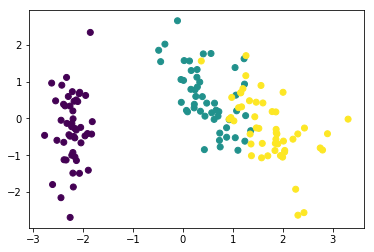

In [9]:
x_std_proj = pca_cov.transform(x_std)

plt.figure()
plt.scatter(x_std_proj[:, 0], x_std_proj[:, 1], c=y)

In [10]:
x_std_back = pca_cov.inverse_transform(x_std_proj)

print(x_std[:5])
print(x_std_back[:5])

[[-0.90068117  1.01900435 -1.34022653 -1.3154443 ]
 [-1.14301691 -0.13197948 -1.34022653 -1.3154443 ]
 [-1.38535265  0.32841405 -1.39706395 -1.3154443 ]
 [-1.50652052  0.09821729 -1.2833891  -1.3154443 ]
 [-1.02184904  1.24920112 -1.34022653 -1.3154443 ]]
[[-0.99888895  1.05319838 -1.30270654 -1.24709825]
 [-1.33874781 -0.06192302 -1.22432772 -1.22057235]
 [-1.36096129  0.32111685 -1.38060338 -1.35833824]
 [-1.42359795  0.0677615  -1.34922386 -1.33881298]
 [-1.00113823  1.24091818 -1.37125365 -1.30661752]]


### PCA implementado pela SVD

In [11]:
pca_svd = MyPCASVD(n_components=2)
pca_svd.fit(x_std)

print('Autovetores: \n', pca_svd.eigen_vectors)
print('Autovalores: \n', pca_svd.eigen_values)
print('Variância explicada: \n', pca_svd.explained_variance_)
print('Variância explicada (ratio): \n', pca_svd.explained_variance_ratio_)

Autovetores: 
 [[ 0.52106591 -0.26934744  0.5804131   0.56485654]
 [-0.37741762 -0.92329566 -0.02449161 -0.06694199]
 [ 0.71956635 -0.24438178 -0.14212637 -0.63427274]
 [ 0.26128628 -0.12350962 -0.80144925  0.52359713]]
Autovalores: 
 [ 20.92306556  11.7091661    4.69185798   1.76273239]
Variância explicada: 
 [ 2.93808505  0.9201649   0.14774182  0.02085386]
Variância explicada (ratio): 
 [ 0.72962445  0.22850762  0.03668922  0.00517871]


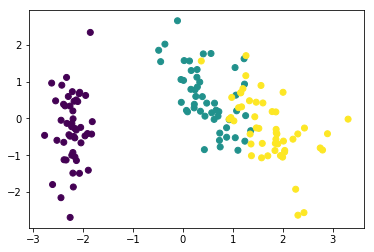

In [12]:
x_std_proj = pca_svd.transform(x_std)

plt.figure()
plt.scatter(x_std_proj[:, 0], x_std_proj[:, 1], c=y)

In [13]:
x_std_back = pca_svd.inverse_transform(x_std_proj)

print(x_std[:5])
print(x_std_back[:5])

[[-0.90068117  1.01900435 -1.34022653 -1.3154443 ]
 [-1.14301691 -0.13197948 -1.34022653 -1.3154443 ]
 [-1.38535265  0.32841405 -1.39706395 -1.3154443 ]
 [-1.50652052  0.09821729 -1.2833891  -1.3154443 ]
 [-1.02184904  1.24920112 -1.34022653 -1.3154443 ]]
[[-0.99888895  1.05319838 -1.30270654 -1.24709825]
 [-1.33874781 -0.06192302 -1.22432772 -1.22057235]
 [-1.36096129  0.32111685 -1.38060338 -1.35833824]
 [-1.42359795  0.0677615  -1.34922386 -1.33881298]
 [-1.00113823  1.24091818 -1.37125365 -1.30661752]]


## Comparação com o Scikit-learn

In [14]:
pca_sk = PCA(n_components=2)
pca_sk.fit(x_std)

print('Autovetores: \n', pca_sk.components_)
print('Autovalores: \n', pca_sk.singular_values_)
print('Variância explicada: \n', pca_sk.explained_variance_)
print('Variância explicada (ratio): \n', pca_sk.explained_variance_ratio_)

Autovetores: 
 [[ 0.52106591 -0.26934744  0.5804131   0.56485654]
 [ 0.37741762  0.92329566  0.02449161  0.06694199]]
Autovalores: 
 [ 20.92306556  11.7091661 ]
Variância explicada: 
 [ 2.93808505  0.9201649 ]
Variância explicada (ratio): 
 [ 0.72962445  0.22850762]


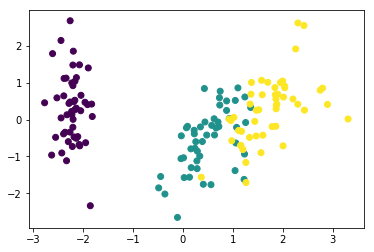

In [15]:
x_std_proj_sk = pca_sk.transform(x_std)

plt.figure()
plt.scatter(x_std_proj_sk[:, 0], x_std_proj_sk[:, 1], c=y)

In [16]:
x_std_back_sk = pca_sk.inverse_transform(x_std_proj_sk)

print(x_std[:5])
print(x_std_back_sk[:5])

[[-0.90068117  1.01900435 -1.34022653 -1.3154443 ]
 [-1.14301691 -0.13197948 -1.34022653 -1.3154443 ]
 [-1.38535265  0.32841405 -1.39706395 -1.3154443 ]
 [-1.50652052  0.09821729 -1.2833891  -1.3154443 ]
 [-1.02184904  1.24920112 -1.34022653 -1.3154443 ]]
[[-0.99888895  1.05319838 -1.30270654 -1.24709825]
 [-1.33874781 -0.06192302 -1.22432772 -1.22057235]
 [-1.36096129  0.32111685 -1.38060338 -1.35833824]
 [-1.42359795  0.0677615  -1.34922386 -1.33881298]
 [-1.00113823  1.24091818 -1.37125365 -1.30661752]]


### Observação sobre a implementação do Scikit-learn

Por algum motivo (que não sei qual), a [implementação do scikit-learn](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/decomposition/pca.py) inverte os sinais de alguns valores na matriz de autovetores. Na implementação, as matrizes $U$ e $V$ são passada para um método ```svd_flip``` (implementada [nesse arquivo](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/utils/extmath.py)):

```py
U, V = svd_flip(U[:, ::-1], V[::-1])
```

Repare que isso muda apenas os dados projetados. No gráfico, isso inverte os eixos correspondentes apenas. No entanto, os **autovalores**, a ```explained_variance```, ```explained_variance_ratio``` e os dados reprojetados ao espaço original são exatamente iguais.

## 5. Referências

- [Antigo notebook do PCA com explicações passo-a-passo](https://github.com/arnaldog12/Machine_Learning/blob/62b628bd3c37ec2fa52e349f38da24751ef67313/PCA.ipynb)
- [Principal Component Analysis in Python](https://plot.ly/ipython-notebooks/principal-component-analysis/)
- [Implementing a Principal Component Analysis (PCA)](https://sebastianraschka.com/Articles/2014_pca_step_by_step.html)
- [Relationship between SVD and PCA. How to use SVD to perform PCA?](https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca)
- [How to reverse PCA and reconstruct original variables from several principal components?](https://stats.stackexchange.com/questions/229092/how-to-reverse-pca-and-reconstruct-original-variables-from-several-principal-com)
- [Everything you did and didn't know about PCA](http://alexhwilliams.info/itsneuronalblog/2016/03/27/pca/)
- [Unpacking (** PCA )](https://towardsdatascience.com/unpacking-pca-b5ea8bec6aa5)